### Importing the Necessary Packages

In [23]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

### Loading the Dataset

In [11]:
data = pd.read_csv('..\data\insurance_data.csv')

C:\Users\Blen\AppData\Local\Temp\ipykernel_23700\1320821194.py:1: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('..\data\insurance_data.csv')


### Ensure the data types are correct (e.g., categorical columns are converted to category type)

In [21]:

categorical_columns = ['Province', 'PostalCode', 'Gender']
for col in categorical_columns:
    data[col] = data[col].astype('category')

# Create a new column for profit margin
data['ProfitMargin'] = data['TotalPremium'] - data['TotalClaims']
data['RiskCategory'] = pd.cut(data['TotalClaims'], bins=[-1, 1000, 5000, np.inf], labels=['Low', 'Medium', 'High'])

In [22]:
data.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,ProfitMargin,RiskCategory
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,21.929825,Low
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,21.929825,Low
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,0.000000,Low
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,2.191491,0.0,2.191491,Low
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,0.000000,Low


### Hypothesis Testing

#### Hypothesis 1: "There are no risk differences across provinces"

##### Step 1: Select Metrics and Segment Data


In [15]:
# Group data by Province and calculate total claims
province_claims = data.groupby('Province')['TotalClaims'].sum()

# Check the total claims by province
print(province_claims)


Province
Eastern Cape     1.356427e+06
Free State       3.549223e+05
Gauteng          2.888766e+07
KwaZulu-Natal    1.430138e+07
Limpopo          1.016477e+06
Mpumalanga       2.044675e+06
North West       5.920250e+06
Northern Cape    8.949051e+04
Western Cape     9.831361e+06
Name: TotalClaims, dtype: float64


C:\Users\Blen\AppData\Local\Temp\ipykernel_23700\2166363227.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  province_claims = data.groupby('Province')['TotalClaims'].sum()


##### Step 2: Feature Selection and Segmentation into Groups

Reject the null hypothesis: There are significant risk differences across provinces.


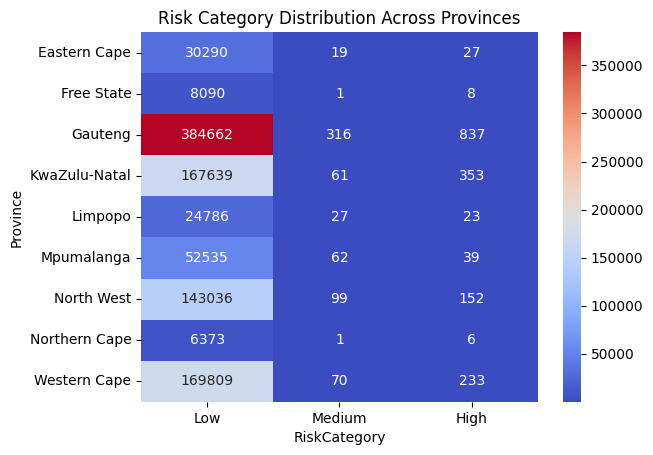

In [25]:
# Create a contingency table of Province vs RiskCategory
contingency_table = pd.crosstab(data['Province'], data['RiskCategory'])

# Perform Chi-Square test for independence
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There are significant risk differences across provinces.")
else:
    print("Fail to reject the null hypothesis: No significant risk differences across provinces.")
    
# Optionally visualize the result
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title('Risk Category Distribution Across Provinces')
plt.show()


##### Step 3: Check for Statistical Equivalence

In [26]:
# Example: Test if VehicleType is equally distributed across provinces

vehicle_type_contingency_table = pd.crosstab(data['Province'], data['VehicleType'])
chi2_stat_vehicle, p_value_vehicle, dof_vehicle, expected_vehicle = chi2_contingency(vehicle_type_contingency_table)

# Interpretation
if p_value_vehicle < alpha:
    print("There is a significant difference in VehicleType distribution across provinces.")
else:
    print("VehicleType distribution is similar across provinces.")


There is a significant difference in VehicleType distribution across provinces.


In [29]:
# Example: Test if Marital Status is equally distributed across provinces

vehicle_type_contingency_table = pd.crosstab(data['Province'], data['MaritalStatus'])
chi2_stat_vehicle, p_value_vehicle, dof_vehicle, expected_vehicle = chi2_contingency(vehicle_type_contingency_table)

# Interpretation
if p_value_vehicle < alpha:
    print("There is a significant difference in Marital Status distribution across provinces.")
else:
    print("Marital Status distribution is similar across provinces.")


There is a significant difference in Marital Status distribution across provinces.


In [30]:
# Example: Test if Gender is equally distributed across provinces

vehicle_type_contingency_table = pd.crosstab(data['Province'], data['Gender'])
chi2_stat_vehicle, p_value_vehicle, dof_vehicle, expected_vehicle = chi2_contingency(vehicle_type_contingency_table)

# Interpretation
if p_value_vehicle < alpha:
    print("There is a significant difference in Marital Status distribution across provinces.")
else:
    print("Marital Status distribution is similar across provinces.")

There is a significant difference in Marital Status distribution across provinces.
